## Coordinate descentベースのLasso推定量の構築

In [1]:
## import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## seed
np.random.seed(42)

### Dataset

In [2]:
## read data
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target
X = X / np.linalg.norm(X,axis=0)  

### Coordinate descentベースのLasso推定量の実装

In [3]:
def classify_threshold(rho,penalty):
    '''
    [DESCRIPTION]
        threshold function used for lasso estimator 
        using a normalized data
    
    [REMARKS]
        JUST MAKE SURE YOU ARE USING A NORMALIZED DATA
    '''

    if rho < - penalty:
        return rho + penalty

    elif rho >  penalty:
        return rho - penalty

    else: 
        return 0

def calculate_dist(A, B):
    return np.sqrt(sum((A - B) ** 2))

def coordinate_descent_lassoestimator(beta,
                                      X,y,
                                      penalty,
                                      max_iter=1000,
                                      eps=1e-10):
    
    #Initialisation of useful values 
    N,K = X.shape
    iter_count = 0
    beta_old = beta.copy() + 10*eps
    beta_updated = beta.copy()
    estimate_dist = calculate_dist(beta_old, beta_updated)

    #Looping until max number of iterations
    while iter_count < max_iter and estimate_dist > eps:
        iter_count += 1
        beta_old = beta_updated.copy()

        for j in range(K):
            X_j = X[:,j].reshape(-1)
            y_pred = X @ beta_updated
            _rho = X_j.T @ (y - y_pred  + beta_updated[j]*X_j)
            beta_updated[j] =  classify_threshold(rho=_rho, penalty=penalty)

        estimate_dist = calculate_dist(beta_old, beta_updated)

    return beta_updated



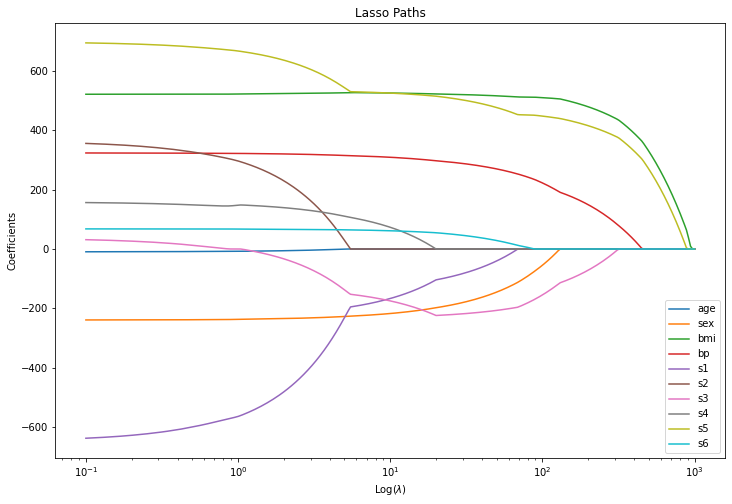

In [4]:
# Initialize variables
n,k = X.shape
initial_beta = np.zeros(k)
beta_list = []
penalty = np.logspace(0,4,300)/10

#Run lasso regression for each lambda
for l in penalty:
    beta = coordinate_descent_lassoestimator(initial_beta,
                                             X,
                                             y,
                                             penalty=l,
                                             max_iter=100)
    beta_list.append(beta)

#Stack into numpy array
beta_lasso = np.stack(beta_list).T

#Plot results
n,_ = beta_lasso.shape
plt.figure(figsize = (12,8))

for i in range(k):
    plt.plot(penalty, beta_lasso[i], label = diabetes.feature_names[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.legend();

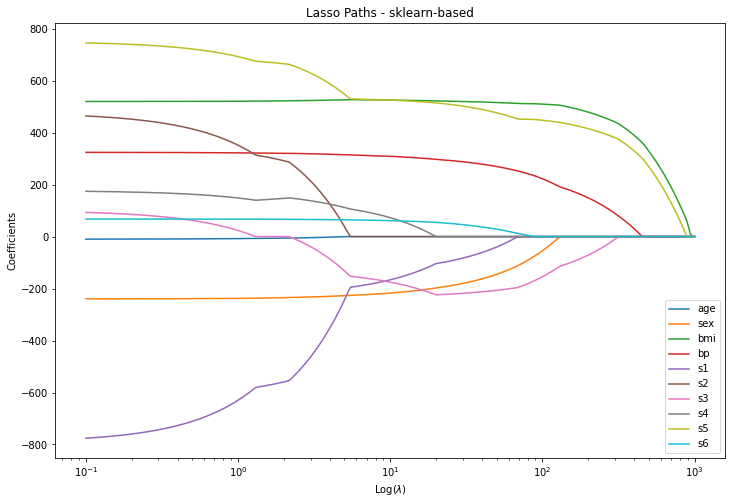

In [5]:
# Initialize variables
n,k = X.shape
initial_beta = np.zeros(k)
beta_list = []
penalty = np.logspace(0,4,300)/10

#Run lasso regression for each lambda
for l in penalty:
    lasso = Lasso(alpha=l/(n), fit_intercept = False)
    lasso.fit(X, y)
    beta = lasso.coef_
    beta_list.append(beta)

#Stack into numpy array
beta_lasso = np.stack(beta_list).T

#Plot results
n,_ = beta_lasso.shape
plt.figure(figsize = (12,8))

for i in range(k):
    plt.plot(penalty, beta_lasso[i], label = diabetes.feature_names[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - sklearn-based')
plt.legend();

### Bias-variance decomposition

In [6]:
## read data
def generate_data(_beta, _mu_x, _std_x, _mu_eps, _std_eps, _N, _P):
    eps = np.random.normal(_mu_eps, _std_eps, _N)
    X = np.random.normal(_mu_x, _std_x, size=(_N, _P))
    y = np.dot(X, _beta) + eps

    return y, X, eps

## parameters
N = 100 # sample size
P = 30    # rank
mu_eps, std_eps = 0, 1
mu_x, std_x = 0, 1

## simulation data
### making coefficients
#beta_1 = np.random.uniform(0.5, 1.0, 5)
#beta_2 = np.random.uniform(-1.0, -0.5, 5)

beta_1 = np.array([0.68727006, 0.97535715, 0.86599697, 0.79932924, 0.57800932])
beta_2 = np.array([-0.92200274, -0.97095819, -0.56691193, -0.69944249, -0.64596371])
beta_3 = np.zeros(20)
beta = np.concatenate([beta_1, beta_2, beta_3], 0)

### creating dataset
y, X, eps = generate_data(beta, mu_x, std_x, mu_eps, std_eps, N, P)

In [7]:
def split_train_test(_y, _X, _split_num):
    X_train, X_test = _X[:_split_num], _X[_split_num:]
    y_train, y_test = _y[:_split_num], _y[_split_num:]

    return X_train, X_test, y_train, y_test
    
def draw_bootstrap_sample(rng, X, y):
    sample_indices = np.arange(X.shape[0])
    bootstrap_indices = rng.choice(sample_indices,
                                   size=sample_indices.shape[0],
                                   replace=True)
    return X[bootstrap_indices], y[bootstrap_indices]

def compute_bias_variance_decomposition(true_estimator,
                                        X_train, 
                                        y_train, 
                                        X_test, 
                                        y_test,
                                        _penalty,
                                        iter_num=20, random_seed=42
                                        ):

    rng = np.random.RandomState(random_seed)
    all_pred = np.zeros((iter_num, y_test.size), dtype=np.float64)
    y_true = X_test @ true_estimator

    for i in range(iter_num):
        X_boot, y_boot = draw_bootstrap_sample(rng, X_train, y_train)
        lasso = Lasso(alpha=_penalty/(2*X_boot.shape[0]), fit_intercept = False)
        lasso.fit(X_boot, y_boot)
        estimate = lasso.coef_

        y_pred = X_test @ estimate
        all_pred[i] = y_pred

    mse = np.apply_along_axis(
            lambda x:
            ((x - y_test)**2).mean(),
            axis=1,
            arr=all_pred).mean()

    
    main_predictions = np.mean(all_pred, axis=0)
    squared_bias = np.sum((main_predictions - y_true)**2) / y_true.size
    mean_variance = np.sum((main_predictions - all_pred)**2) / all_pred.size

    return mse, squared_bias, mean_variance

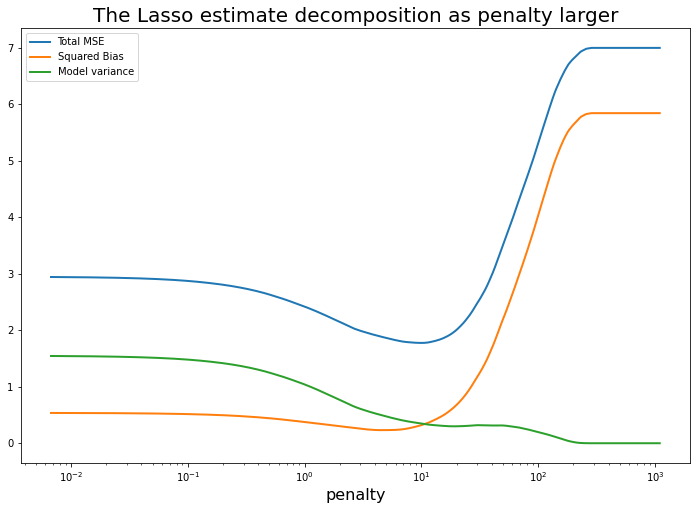

In [8]:
## simulation params
split_num = 70
iter_num = 1000
penalty_range = np.exp(np.linspace(-5, 7, iter_num))
result = np.empty((iter_num, 3))

## generate data
X_train, X_test, y_train, y_test = split_train_test(y, X, split_num)


for array_index, _penalty in enumerate(penalty_range):
    result[array_index,:] = compute_bias_variance_decomposition(true_estimator=beta,
                                                                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                                                                iter_num=20, random_seed=42,
                                                                _penalty = _penalty)

## plot
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(penalty_range,result,label = ['Total MSE', 'Squared Bias', 'Model variance'],lw=2)
ax.set_title('The Lasso estimate decomposition as penalty larger', fontsize=20)
ax.set_xlabel('penalty', fontsize=16)
ax.set_xscale('log')
ax.legend();